This script was writtent to complete a lab from my Intro to GIS class that I orginally did all in ArcMap.
I took on the challenge of completing the objective of the lab only through python script. 
The Obejecive of the lab was to complete spatial analysis through query. 
The lab focused on analyzing inventory data from a Forest and determining which set of forest stands meet the criteria for harvest based on certain parameters.
In this script I include questions from the lab that I answer.

The parameters for a harvest stand to be met include: 

1. Owned by the University of Montana 
2. Must be between the ages of 70-125 years old. 
3. Cannot be adjacent to young stands that are between the age 1-20 years old. 
4. Cannot be within 250 meters of old stands that are between 150 and >200 years old. 
5. Cannot have monitoring plots within them 
6. Must have to be on land with a slope ranging from 0-15% 
7. Must be within 100 m of a road 
8. Cannot be within 20 m of a stream
 All of these parameters had to be true to determine if a forest stand was harvestable. To figure this out I systematically went through the data checking for each parameter and removed non harvest stands until I had stands that met the criteria. 

The data I used for this included:
-Shape files of forest boundary, forest stands, perenial streams, and roads. 
-Forest inventory table that had information for each each stand, which I then joined with the forest stands polygon layer. 
-XY data of points that showed where monitoring plots were. 


In [1]:
import geopandas as gpd

In [2]:
import matplotlib.pyplot as plt

In [3]:
from shapely.geometry import Point, LineString, Polygon

In [4]:
import shapely.speedups

In [5]:
import numpy as np

In [6]:
%matplotlib inline

In [7]:
bound_fp="/users/haleybrueckman/desktop/computer_practice/python/Lab9_Raw_Data/boundary.shp"

In [8]:
foreststands_fp="/users/haleybrueckman/desktop/computer_practice/python/Lab9_Raw_Data/Forest_stands.shp"

In [9]:
pernrf3_fp="/users/haleybrueckman/desktop/computer_practice/python/Lab9_Raw_Data/perennial_RF3.shp"

In [10]:
roadclass_fp="/users/haleybrueckman/desktop/computer_practice/python/Lab9_Raw_Data/Road_classes.shp"

In [11]:
forestinven_fp="/users/haleybrueckman/desktop/computer_practice/python/Lab9_Raw_Data/forest_inventory.dbf"

In [12]:
forinv=gpd.read_file(forestinven_fp)

In [13]:
forest=gpd.read_file(foreststands_fp)

In [14]:
pern=gpd.read_file(pernrf3_fp)

In [15]:
road=gpd.read_file(roadclass_fp)

Checked that the coordinate systems matched in all the layers

In [16]:
bound=gpd.read_file(bound_fp)

In [17]:
assert_list = [bound, road, pern, forest]

In [18]:
for a in assert_list:
    for l in assert_list:
        assert a.crs == l.crs , "CRS differs between layers"

Determined area and made a new attribute column that displays area in acres. Since the projection is uses meters I converted it to acres by dividing it by 4,047

In [19]:
forest['Area']=forest.area/4047

In [20]:
forinv=forinv.drop(columns=['geometry'])

merged the table from forest inventory that had no geospatial data with the forest stands one by linking through the column SLINK2000

In [21]:
cutblocks=forest.merge(forinv, on='SLINK2000')

In [22]:
cutblocksfp="/users/haleybrueckman/desktop/computer_practice/python/Lab9_Raw_Data/cutblocks.shp"

In [23]:
cutblocks.to_file(cutblocksfp)

In [24]:
cutblock=gpd.read_file(cutblocksfp)

Solidifed the join by downloading it as a new shapefile called cutblock

Question 1: 1. How many stands are in the Cutblocks layer? What is their combined area?

In [25]:
stand_area=cutblock['Area'].sum()
print(stand_area)

43607.75658197597


In [26]:
stand_num=len(cutblock.index)
print(stand_num)

1998


Question 2: To limit all further analyses to this ownership class, open the properties window for the Cutblocks layer and build the following statement in the Query Builder on the Definition Query tab: "OWNER" = 1

Now how many stands are in the Cutblocks layer? What is their combined area?

In [27]:
group_owner=cutblock.groupby('OWNER')

In [28]:
group_owner.groups.keys()

dict_keys([0, 1, 2, 3, 4, 7, 9])

In [29]:
for key, group in group_owner:
    print('Owner:', key)
    print('number of rows:', len(group), "\n")

Owner: 0
number of rows: 9 

Owner: 1
number of rows: 1093 

Owner: 2
number of rows: 341 

Owner: 3
number of rows: 324 

Owner: 4
number of rows: 10 

Owner: 7
number of rows: 214 

Owner: 9
number of rows: 7 



one option is to group the data in table by owner and then make seperate shapefiles of these seperate owners and their rows

In [30]:
cb_owner1=cutblock[cutblock['OWNER']==1]

In [31]:
cb_owner1.head()

,SLINK2000,Area,STAND_ID,TOWNSHIP,RANGE,SECTION,STAND,OWNER,AERIAL,USGS,...,TPA1_5,BA9_15,BA15,DBH9_15,DBH15,TPA9_15,TPA15,REMARKS,RECORDER,geometry
0,1,60.486098,14152001,14,15,20,1,1,920207,4,...,07,2,2,14,19,19,10,PERM. PLOT #89.,D.WOOD,"POLYGON ((308475.406 5202922.000, 308461.000 5..."
1,2,8.220409,14151902,14,15,19,2,1,920107,4,...,08,13,8,2,20,5959,37,"ORANGE 58 OTHER ORANGE PAINT MARKINGS, MANY FO...",J.MOGILEFSKY,"POLYGON ((306507.281 5202747.000, 306505.656 5..."
2,3,14.559331,14152012,14,15,20,12,1,920309,4,...,07,0,0,0,0,0,0,HEAVY GRAZING AREA,J.MOGILEFSKY,"POLYGON ((308475.406 5202922.000, 308488.312 5..."
3,4,83.353784,14152007,14,15,20,7,1,920207,4,...,None,0,0,0,0,0,0,CURLEY WEST MEADOW T.S.,D.WOOD,"POLYGON ((308334.594 5202806.000, 308367.688 5..."
4,5,14.954706,14151903,14,15,19,3,1,920107,4,...,09,6,0,11,0,91,0,"SEED/SAP/POLE 1-4.9)SMALL, AND MEDIUM SIZE CLA...",J.MOGILEFSKY,"POLYGON ((306507.281 5202747.000, 306512.844 5..."


In [32]:
print (len(cb_owner1.index))

1093


There are 1093 stands

another option is to select out all the rows with owner 1 and to not go through the trouble of making a seperate shapefile. now you can find the sum of the area.

In [33]:
print (cb_owner1['Area'].sum())

19994.254885311628


There are 19,994 acres

3. How many stands are in the age group 70-125

In [34]:
cb_70_125=cb_owner1[cb_owner1['STAND_AGE'].isin(['08', '09', '10', '11'])]

same method of selecting out of the last selection but this time selecting multiple values in the attribute column

In [35]:
print(len(cb_70_125.index))

467


467 trees are 70-125 in age

4. How many trees of the current selection are adjacent/touching trees that are in age classes 1-2? Remove the trees that are adjacent. 

First I created a dataframe that had young trees in groups 01 and 02

In [36]:
young_forest=cutblock[cutblock['STAND_AGE'].isin(['01','02'])]

In [37]:
yfp="/users/haleybrueckman/desktop/computer_practice/python/Lab9_Raw_Data/young_forest.shp"

In [38]:
young_forest.to_file(yfp)

In [39]:
young_forest=gpd.read_file(yfp)

<AxesSubplot:>

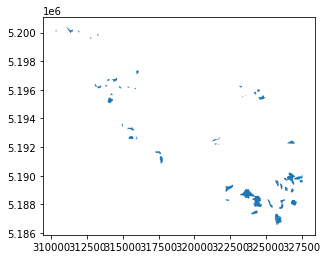

In [40]:
young_forest.plot()

In [41]:
print(len(young_forest.index))

53


In [42]:
print(len(cb_70_125.index))

467


<AxesSubplot:>

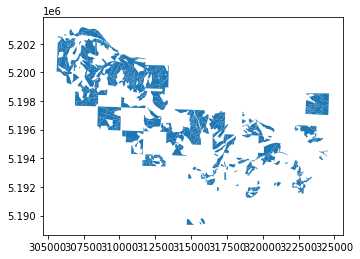

In [43]:
cb_70_125.plot()

I also solidified my selection layer by making it a shapefile and then reading it back into python

In [44]:
cbfp="/users/haleybrueckman/desktop/computer_practice/python/Lab9_Raw_Data/cutblocks.shp"

In [45]:
cb_70_125.to_file(cbfp)

In [46]:
cb_70_125=gpd.read_file(cbfp)

To find young trees that are adjacent to the current selection I did .touches()

This gave me a lot of trouble because .touches() functions in a way that in a 1 to 1 row wise manner. It does not check if an element of one GeoSeries touches ANY element of the other one. But it can check if each geometry of GeoSeries touches a SINGLE geometry. 

This is why a unary_union had to be applied to young_forest because it then combined all the young forest polygons to be a single geometry that cb_70_125 could run against. 

In [47]:
adjacent=cb_70_125.touches(young_forest.unary_union)

In [48]:
adjacent_sum=sum(adjacent)
print(adjacent_sum)

32


In [49]:
cb_70_125['young_adjacent']=adjacent

In [50]:
adj_young=cb_70_125[cb_70_125['young_adjacent']==False]

In [51]:
adj_young

,SLINK2000,Area,STAND_ID,TOWNSHIP,RANGE,SECTION,STAND,OWNER,AERIAL,USGS,...,BA9_15,BA15,DBH9_15,DBH15,TPA9_15,TPA15,REMARKS,RECORDER,geometry,young_adjacent
0,1,60.486098,14152001,14,15,20,1,1,920207,4,...,2,2,14,19,19,10,PERM. PLOT #89.,D.WOOD,"POLYGON ((308475.406 5202922.000, 308461.000 5...",False
1,2,8.220409,14151902,14,15,19,2,1,920107,4,...,13,8,2,20,5959,37,"ORANGE 58 OTHER ORANGE PAINT MARKINGS, MANY FO...",J.MOGILEFSKY,"POLYGON ((306507.281 5202747.000, 306505.656 5...",False
2,3,14.559331,14152012,14,15,20,12,1,920309,4,...,0,0,0,0,0,0,HEAVY GRAZING AREA,J.MOGILEFSKY,"POLYGON ((308475.406 5202922.000, 308488.312 5...",False
3,4,83.353784,14152007,14,15,20,7,1,920207,4,...,0,0,0,0,0,0,CURLEY WEST MEADOW T.S.,D.WOOD,"POLYGON ((308334.594 5202806.000, 308367.688 5...",False
4,5,14.954706,14151903,14,15,19,3,1,920107,4,...,6,0,11,0,91,0,"SEED/SAP/POLE 1-4.9)SMALL, AND MEDIUM SIZE CLA...",J.MOGILEFSKY,"POLYGON ((306507.281 5202747.000, 306512.844 5...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,1651,0.314120,13142617,13,14,26,17,1,921108,2,...,6,1,12,17,76,6,None,J.MOGILEFSKY,"POLYGON ((322715.875 5191581.000, 322729.469 5...",False
463,1668,8.840089,13142802,13,14,28,2,1,920905,2,...,7,2,12,23,89,7,SCATTERED DEAD LPP,J.MOGILEFSKY,"POLYGON ((319200.625 5191332.000, 319162.344 5...",False
464,1905,16.465851,13143106,13,14,31,6,1,920704,5,...,3,2,12,17,38,13,None,J.MOGILEFSKY,"POLYGON ((315927.469 5189407.000, 315911.094 5...",False
465,1911,29.168563,13143104,13,14,31,4,1,920704,5,...,0,0,0,0,0,0,LIVESTOCK USE STAND FOR SHADE FROM UNFENCED DS...,J.MOGILEFSKY,"POLYGON ((315208.344 5189349.500, 315068.312 5...",False


In [52]:
adjfp="/users/haleybrueckman/desktop/computer_practice/python/Lab9_Raw_Data/adj_young.shp"

In [53]:
adj_young.to_file(adjfp)

<ipython-input-53-c2a0fb781035>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  adj_young.to_file(adjfp)


In [54]:
adj_y=gpd.read_file(adjfp)

4. Answer: There are now 435 trees left in the selection. 32 were removed because they were adjacent to young stands. 

First create a layer that has only the stands in groups 13 and 14, which is the code for the trees from age 150 and older

In [55]:
other_trees=cutblock[cutblock['STAND_AGE'].isin(['13','14'])]

created a buffer of 250 meters from the geometries of trees that are 150 or older. I could just put in 250 without indicating units because .buffer() uses the crs dimensions, which in this case is in meters.

In [56]:
other_trees['250_buffer']=other_trees['geometry'].buffer(250)


/Users/haleybrueckman/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:>

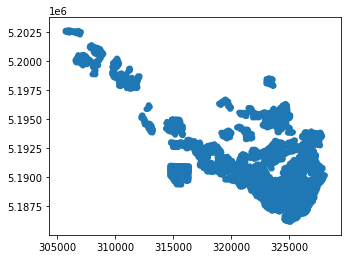

In [57]:
other_trees['250_buffer'].plot()

created a geoseriers that contains boolean values indicating if adj_y geometires intersect at all with the the other_trees buffer of 250 meters. Had to do a unary_union again so that other trees was considered one geometry to avoid problems with indexes. Also tried .within() first, but it seems that only brings back geometries that are completely within a selection.

In [58]:
buffer=adj_y.intersects(other_trees['250_buffer'].unary_union)

In [59]:
buffer_sum=sum(buffer)
print(buffer_sum)

205


In [60]:
adj_y['250_buffer']=buffer

In [61]:
buffer1=adj_y[adj_y['250_buffer']==False]

In [62]:
print (buffer1['Area'].sum())

4335.330472927953


Questions 5 and 6: 5.	This spatial query removed stands of trees from the Cut_Block layer that were aged 150 to greater than 200 years old and were within 250 meters of the current selected stands(adj_y). There are now 230 trees in the selction and their total area in acres is 4,335

Question 7: This spatial query removes the plots that are monitoring plots. Sample_points has x and y coordinates that indicate the monitoring plots. 

In [63]:
sample_pointfp="/users/haleybrueckman/desktop/computer_practice/python/Lab9_Raw_Data/sample_point.dbf"
sample_point=gpd.read_file(sample_pointfp)

In [64]:
sample_point.head()

,PLOTID,MSP_X,MSP_Y,UTM_X,UTM_Y,DD_LAT,DD_LONG,RANDOMVALU,INVGROUP,geometry
0,1,291802.6151,307889.5295,305752.3332,5.202663e+06,46.949030,-113.552660,0.9479,0,None
1,2,292702.6151,307889.5295,306652.7695,5.202680e+06,46.949449,-113.540847,0.7472,0,None
2,3,293602.6151,307889.5295,307553.2021,5.202698e+06,46.949866,-113.529033,0.9663,0,None
3,4,294502.6151,307889.5295,308453.6308,5.202715e+06,46.950282,-113.517219,0.6080,0,None
4,5,291802.6151,306989.5295,305769.6026,5.201763e+06,46.940941,-113.552049,0.2414,1,None


After reading the sample_point file in, i utilized the UTM_x and UTM_y coordinates and zipped them together to create coordinate points that function as the geometry column in the geodataframe. I chose to use the UTM coordiantes because that is the projection of the other geodataframes. 

In [65]:
sample_point['geometry'] = [Point(xy) for xy in zip(sample_point.UTM_X, sample_point.UTM_Y)]

In [66]:
sample_point.head()

,PLOTID,MSP_X,MSP_Y,UTM_X,UTM_Y,DD_LAT,DD_LONG,RANDOMVALU,INVGROUP,geometry
0,1,291802.6151,307889.5295,305752.3332,5.202663e+06,46.949030,-113.552660,0.9479,0,POINT (305752.333 5202663.088)
1,2,292702.6151,307889.5295,306652.7695,5.202680e+06,46.949449,-113.540847,0.7472,0,POINT (306652.769 5202680.356)
2,3,293602.6151,307889.5295,307553.2021,5.202698e+06,46.949866,-113.529033,0.9663,0,POINT (307553.202 5202697.623)
3,4,294502.6151,307889.5295,308453.6308,5.202715e+06,46.950282,-113.517219,0.6080,0,POINT (308453.631 5202714.889)
4,5,291802.6151,306989.5295,305769.6026,5.201763e+06,46.940941,-113.552049,0.2414,1,POINT (305769.603 5201762.650)


<AxesSubplot:>

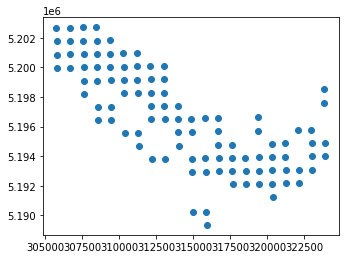

In [67]:
sample_point.plot()

next I figured out which of buffer1 polygons intersected with the monitoring plots. Again I used unary_union to avoid issues with the indexes. I also found that I could do sample_point.within(buffer1.unary_union) and get the same results, but then I wasnt able to determine which of the polygons in buffer1 contained the monitoring plots, because unary_union joined the polygons to be one geometry. I also tried .contain() but this came back with 0. Im not sure what .contains does in geopandas. I assumed it was the opposite of .within(), but that didnt seem to be true. 

In [68]:
point_contain=buffer1.intersects(sample_point.unary_union)

In [69]:
point_sum=sum(point_contain)
print(point_sum)

23


In [70]:
buffer1['sample_point']=point_contain

/Users/haleybrueckman/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [71]:
perm_plot=buffer1[buffer1['sample_point']==False]

In [72]:
perm_plot

,SLINK2000,Area,STAND_ID,TOWNSHIP,RANGE,SECTION,STAND,OWNER,AERIAL,USGS,...,DBH9_15,DBH15,TPA9_15,TPA15,REMARKS,RECORDER,young_adja,geometry,250_buffer,sample_point
2,3,14.559331,14152012,14,15,20,12,1,920309,4,...,0,0,0,0,HEAVY GRAZING AREA,J.MOGILEFSKY,0,"POLYGON ((308475.406 5202922.000, 308488.312 5...",False,False
5,6,17.925251,14152102,14,15,21,2,1,920309,4,...,11,21,61,4,None,J.MOGILEFSKY,0,"POLYGON ((308610.750 5202787.500, 308708.688 5...",False,False
7,8,6.646799,14152009,14,15,20,9,1,920207,4,...,0,0,0,0,VERY STEEP - 75%,D.WOOD,0,"POLYGON ((307644.094 5202654.000, 307760.688 5...",False,False
8,10,23.564807,14152101,14,15,21,1,1,920309,4,...,12,20,51,5,None,J.MOGILEFSKY,0,"POLYGON ((308632.125 5202624.000, 308736.719 5...",False,False
17,31,13.612551,14152819,14,15,28,19,1,920309,4,...,11,18,76,6,None,J.MOGILEFSKY,0,"POLYGON ((308846.281 5202229.000, 308888.094 5...",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,1270,4.967059,13142026,13,14,20,26,1,920813,5,...,0,0,0,0,MANY LARCH SNAGS; PILEATED NEST HOLE.,D.WOOD,0,"POLYGON ((317581.938 5193359.000, 317577.594 5...",False,False
391,1338,2.823199,13142120,13,14,21,20,1,920906,5,...,12,17,13,6,WET MEADOW IN SPRING TO EARLY SUMMER,J.MOGILEFSKY,0,"POLYGON ((318264.750 5193156.000, 318258.125 5...",False,False
393,1350,11.082762,13142361,13,14,23,61,1,921108,2,...,13,0,54,0,WILLOW CLUMPS,J.MOGILEFSKY,0,"POLYGON ((322706.375 5193038.000, 322733.500 5...",False,False
396,1374,7.752189,13142360,13,14,23,60,1,921108,2,...,13,21,43,12,None,J.MOGILEFSKY,0,"POLYGON ((322836.281 5192920.000, 322815.094 5...",False,False


Answer Question 7: 23 stands were removed from this query based on if they are monitoring plots. This leaves 207 stands selected in Cut_Block.

Question 8: select plots that have a slope from 0-15%

First i grouped the perm_plot selection by SLPCLASS, and then wrote code to determine the differnt attributes for this field and realized I needed to select plots with an SLPCLASS of 0-4% and 0-5%. 

In [73]:
group_slp=perm_plot.groupby('SLPCLASS')

In [74]:
for key, group in group_slp:
    print('slp:', key)
    print('number of rows:', len(group), "\n")

slp: 0-4%
number of rows: 3 

slp: 16-30%
number of rows: 103 

slp: 31-45%
number of rows: 34 

slp: 5-15%
number of rows: 67 



I made my selection of plots that had a slope of 5-15%.

In [75]:
slope_select=perm_plot[perm_plot['SLPCLASS'].isin(['0-4%', '5-15%'])]

In [76]:
slope_select

,SLINK2000,Area,STAND_ID,TOWNSHIP,RANGE,SECTION,STAND,OWNER,AERIAL,USGS,...,DBH9_15,DBH15,TPA9_15,TPA15,REMARKS,RECORDER,young_adja,geometry,250_buffer,sample_point
2,3,14.559331,14152012,14,15,20,12,1,920309,4,...,0,0,0,0,HEAVY GRAZING AREA,J.MOGILEFSKY,0,"POLYGON ((308475.406 5202922.000, 308488.312 5...",False,False
5,6,17.925251,14152102,14,15,21,2,1,920309,4,...,11,21,61,4,None,J.MOGILEFSKY,0,"POLYGON ((308610.750 5202787.500, 308708.688 5...",False,False
8,10,23.564807,14152101,14,15,21,1,1,920309,4,...,12,20,51,5,None,J.MOGILEFSKY,0,"POLYGON ((308632.125 5202624.000, 308736.719 5...",False,False
60,116,57.043239,14152701,14,15,27,1,1,920409,3,...,11,15,61,8,None,D.WOOD,0,"POLYGON ((311805.031 5200721.500, 311798.625 5...",False,False
68,137,30.535683,14153519,14,15,35,19,1,920509,3,...,0,0,0,0,"UNBURNED SLASH PILES IN OLD LANDING, RESEARCH ...",J.MOGILEFSKY,0,"POLYGON ((312311.844 5200503.000, 312365.094 5...",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1229,13.094852,13152302,13,15,23,2,1,920504,5,...,12,20,51,9,None,J.MOGILEFSKY,0,"POLYGON ((311923.938 5193678.000, 311917.438 5...",False,False
377,1233,12.878772,13142333,13,14,23,33,1,921108,2,...,14,0,9,0,None,J.MOGILEFSKY,0,"POLYGON ((322274.969 5193593.000, 322289.469 5...",False,False
379,1236,8.825015,13152315,13,15,23,15,1,920504,5,...,0,0,0,0,HORSE LOGGED,J.MOGILEFSKY,0,"POLYGON ((312302.062 5193636.000, 312330.344 5...",False,False
384,1269,15.180044,13142325,13,14,23,25,1,921108,2,...,12,18,89,6,None,J.MOGILEFSKY,0,"POLYGON ((322600.906 5193452.000, 322609.500 5...",False,False


Answer Question 8: There are now 70 stands selected in the Cut_Block layer selected by if they have a slope of 0-15 percent. 

Question 9: remove any of the plots that are not within 100 meters of a road

First I buffered the road geometry by 100 meters

In [77]:
road_buffer_100m=road['geometry'].buffer(100)

In [78]:
road['buffer_100m']=road_buffer_100m

next i found which polygons of the current selection intersect with this 100 meter road buffer.  

In [79]:
road_intersect=slope_select.intersects(road['buffer_100m'].unary_union)

In [80]:
road_sum=sum(road_intersect)
print(road_sum)

49


In [81]:
slope_select['road_buffer_100m']=road_intersect


/Users/haleybrueckman/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


I selected to the polygons in which it was true that they were within 100 meters of a road

In [82]:
road_buffer=slope_select[slope_select['road_buffer_100m']==True]

In [83]:
road_buffer

,SLINK2000,Area,STAND_ID,TOWNSHIP,RANGE,SECTION,STAND,OWNER,AERIAL,USGS,...,DBH15,TPA9_15,TPA15,REMARKS,RECORDER,young_adja,geometry,250_buffer,sample_point,road_buffer_100m
2,3,14.559331,14152012,14,15,20,12,1,920309,4,...,0,0,0,HEAVY GRAZING AREA,J.MOGILEFSKY,0,"POLYGON ((308475.406 5202922.000, 308488.312 5...",False,False,True
5,6,17.925251,14152102,14,15,21,2,1,920309,4,...,21,61,4,None,J.MOGILEFSKY,0,"POLYGON ((308610.750 5202787.500, 308708.688 5...",False,False,True
8,10,23.564807,14152101,14,15,21,1,1,920309,4,...,20,51,5,None,J.MOGILEFSKY,0,"POLYGON ((308632.125 5202624.000, 308736.719 5...",False,False,True
60,116,57.043239,14152701,14,15,27,1,1,920409,3,...,15,61,8,None,D.WOOD,0,"POLYGON ((311805.031 5200721.500, 311798.625 5...",False,False,True
68,137,30.535683,14153519,14,15,35,19,1,920509,3,...,0,0,0,"UNBURNED SLASH PILES IN OLD LANDING, RESEARCH ...",J.MOGILEFSKY,0,"POLYGON ((312311.844 5200503.000, 312365.094 5...",False,False,True
69,138,14.947950,14153522,14,15,35,22,1,920509,3,...,0,0,0,PORTION OF STAND IS LEAVE TREE MARKED,J.MOGILEFSKY,0,"POLYGON ((312365.094 5200501.000, 312371.469 5...",False,False,True
78,158,20.738176,14153517,14,15,35,17,1,920509,3,...,0,0,0,DOUGLAS FIR REGENERATION,J.MOGILEFSKY,0,"POLYGON ((312772.875 5200366.000, 312814.312 5...",False,False,True
83,167,16.039821,14153515,14,15,35,15,1,920509,3,...,17,102,13,"JEEP TRAIL INTO STAND, BUDWORM DAMAGE",J.MOGILEFSKY,0,"POLYGON ((312624.781 5200235.000, 312752.781 5...",False,False,True
89,190,19.867702,14153511,14,15,35,11,1,920509,3,...,0,0,0,RIPARIAN PATCH IN CENTER UPLAND PORTION IS SNO...,J.MOGILEFSKY,0,"POLYGON ((312280.375 5199973.000, 312272.281 5...",False,False,True
90,193,3.389791,14153516,14,15,35,16,1,920509,3,...,18,11,6,JEEP TRAIL INTO STAND,J.MOGILEFSKY,0,"POLYGON ((312851.062 5199957.000, 312789.969 5...",False,False,True


Answer to question 9: There are now 49 stands selected in the Cut_Block layer selected by if they are within 100 meters of a road

Question 10: remove any plots within current selection that are within 20 meters of a stream.

Using the same process of the other buffers, I buffered the perrenial streams by 20 meters and then figured out which of the current selection of cutblocks intersected with this buffer



In [84]:
pern['pern_buffer']=pern['geometry'].buffer(20)

stream_20m=road_buffer.intersects(pern['pern_buffer'].unary_union)

stream_sum=sum(stream_20m)
print(stream_sum)

road_buffer['stream_buffer_20m']=stream_20m

final_Cutblocks=road_buffer[road_buffer['stream_buffer_20m']==False]

16


/Users/haleybrueckman/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Question 10 Answer:
There are 33 stands left selected in the Cut_Block layer that are not within 20 meters of a stream. 


<AxesSubplot:>

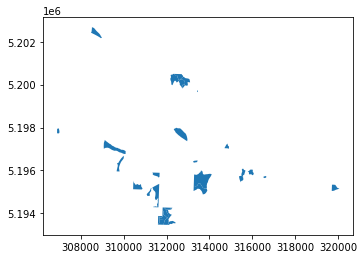

In [85]:
final_Cutblocks.plot()

In [86]:
print(len(final_Cutblocks.index))

33


In [87]:
final_cutblocksfp="/users/haleybrueckman/desktop/computer_practice/python/Lab9_Raw_Data/final_cutblocks.shp"

final_cutblocks.to_file(final_cutblocksfp)

NameError: name 'final_cutblocks' is not defined